# Acoustic Maze Navigation - Dataset Generation

**Goal**: Generate dataset for acoustic navigation by simulating sound propagation in mazes with proper maze generation and action labels.

## What we're doing:
1. Generate structured mazes using mazelib (Prim's algorithm)
2. Compute action labels (vector field) for supervised learning
3. Simulate sound propagation using k-Wave
4. Record full pressure time-series at ALL grid points
5. Save maze + acoustic data + labels for training

## Dataset Structure:
- **Maze grid**: Wall/air layout
- **Action grid**: Optimal move direction at each position (UP/DOWN/LEFT/RIGHT/STOP)
- **Pressure time-series**: Acoustic data at every grid point over time
- **Metadata**: Source position, resolution, frequency, etc.

In [23]:
import sys
sys.path.append('../data')

import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from scipy import signal as scipy_signal
from scipy.fft import fft, fftfreq

# Import and reload to get latest changes
import audio_maze
import audio_cave
import importlib
importlib.reload(audio_maze)
importlib.reload(audio_cave)
from audio_maze import AudioMaze
from audio_cave import AudioCave

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksource import kSource
from kwave.ksensor import kSensor
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.options.simulation_options import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.signals import tone_burst

## 1. Configuration

### Dataset Settings

In [24]:
# Dataset parameters
NUM_MAZES = 5  # Number of different cave scenes to generate
OUTPUT_DIR = Path('../dataset')
OUTPUT_DIR.mkdir(exist_ok=True)

# USE CAVE GENERATOR (not traditional maze)
USE_CAVE = True  # True = natural caves, False = traditional maze

# Grid settings
CAVE_WIDTH = 60   # Cave dimensions
CAVE_HEIGHT = 60
MIN_CORRIDOR_WIDTH = 3  # Minimum 3 cells for 8-mic array
WALL_THICKNESS_RANGE = (1, 10)  # Variable wall thickness for realistic acoustics

dx = dy = 1e-2   # 1 cm resolution

# Physical constants
c_air = 343.0      # Sound speed in air (m/s)
rho_air = 1.2      # Air density (kg/m³)
c_wall = 220.0     # Sound speed in walls (slower = more reflection)
alpha_power = 1.5  # Frequency power law for absorption
wall_absorption_db_per_cm = 1.0  # Wall absorption (dB per cm at f0)

# Source settings
f0 = 15000.0       # 15 kHz frequency (good for echolocation)
num_cycles = 6     # Tone burst cycles
sim_duration = 4e-3  # 4 ms simulation

print(f"Dataset Configuration:")
print(f"  Environment: {'CAVE (natural)' if USE_CAVE else 'MAZE (structured)'}")
print(f"  Scenes to generate: {NUM_MAZES}")
print(f"  Dimensions: {CAVE_WIDTH}x{CAVE_HEIGHT}")
print(f"  Min corridor width: {MIN_CORRIDOR_WIDTH} cells (for 8-mic array)")
print(f"  Wall thickness: {WALL_THICKNESS_RANGE[0]}-{WALL_THICKNESS_RANGE[1]} cells (variable)")
print(f"  Resolution: {dx*100:.1f} cm")
print(f"  Physical size: ~{CAVE_WIDTH*dx:.1f}m × {CAVE_HEIGHT*dy:.1f}m")
print(f"  Source: {f0/1000:.1f} kHz, {num_cycles} cycles")
print(f"  Simulation: {sim_duration*1000:.1f} ms")
print(f"  Output: {OUTPUT_DIR}")

Dataset Configuration:
  Environment: CAVE (natural)
  Scenes to generate: 5
  Dimensions: 60x60
  Min corridor width: 3 cells (for 8-mic array)
  Wall thickness: 1-10 cells (variable)
  Resolution: 1.0 cm
  Physical size: ~0.6m × 0.6m
  Source: 15.0 kHz, 6 cycles
  Simulation: 4.0 ms
  Output: ..\dataset


## 2. Generate Cave/Maze with Action Labels

Using cave generator for natural, irregular spaces with variable wall thickness

Generating CAVE environment (natural, irregular)...

Environment generated: 60x60
Walls: 44.4%
Air: 55.6%
Source position (goal): (51, 45)
Action at goal: 'stop'
Total navigable cells: 2,003


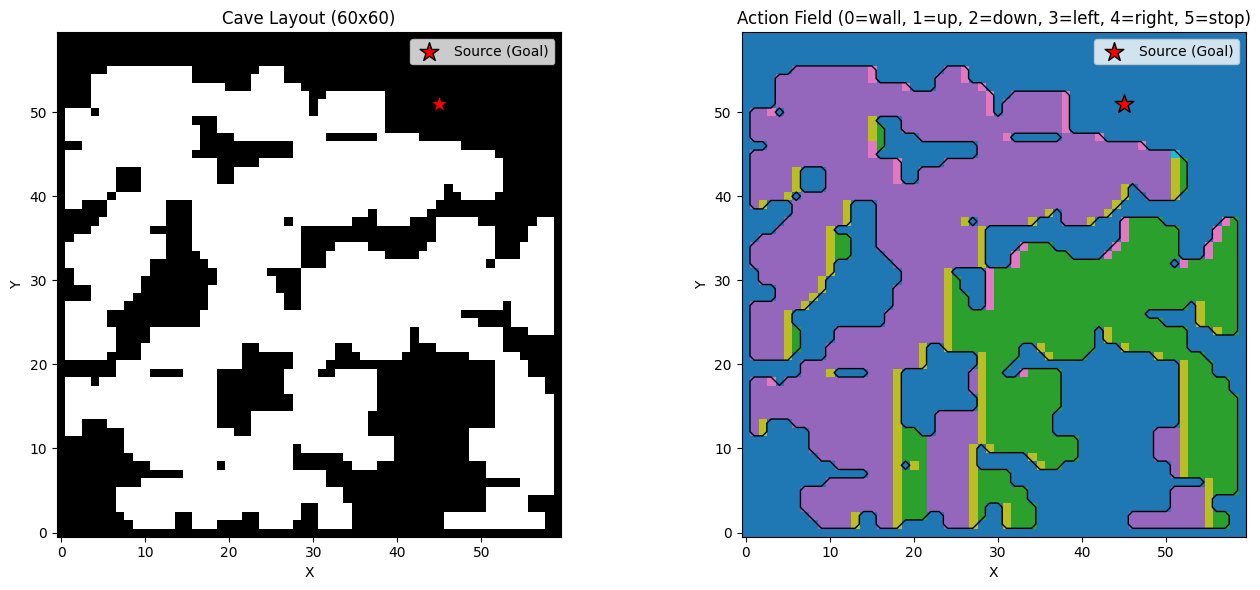

In [25]:
# Generate environment
if USE_CAVE:
    print("Generating CAVE environment (natural, irregular)...")
    env = AudioCave(
        width=CAVE_WIDTH,
        height=CAVE_HEIGHT,
        min_corridor_width=MIN_CORRIDOR_WIDTH,
        wall_thickness_range=WALL_THICKNESS_RANGE
    )
    maze_grid = env.grid
    action_grid = np.array(env.action_grid)
    source_pos = env.end
else:
    print("Generating MAZE environment (structured)...")
    env = AudioMaze(CAVE_WIDTH//2, CAVE_HEIGHT//2, corridor_width=MIN_CORRIDOR_WIDTH)
    maze_grid = env.maze.grid
    action_grid = np.array(env.action_grid)
    source_pos = env.maze.end

source_y, source_x = source_pos

print(f"\nEnvironment generated: {maze_grid.shape[0]}x{maze_grid.shape[1]}")
print(f"Walls: {100*maze_grid.mean():.1f}%")
print(f"Air: {100*(1-maze_grid.mean()):.1f}%")
print(f"Source position (goal): ({source_y}, {source_x})")
print(f"Action at goal: '{action_grid[source_y, source_x]}'")

# Check navigable space
air_cells = np.argwhere(maze_grid == 0)
print(f"Total navigable cells: {len(air_cells):,}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Layout
axes[0].imshow(maze_grid.T, origin='lower', cmap='binary')
axes[0].scatter([source_x], [source_y], s=200, c='red', marker='*', 
               edgecolors='black', linewidths=1, label='Source (Goal)', zorder=10)
axes[0].set_title(f'{'Cave' if USE_CAVE else 'Maze'} Layout ({maze_grid.shape[0]}x{maze_grid.shape[1]})')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend()
axes[0].axis('image')

# Action field
symbol_map = {"up": 1, "down": 2, "left": 3, "right": 4, "stop": 5, "": 0}
action_numeric = np.vectorize(symbol_map.get)(action_grid)
axes[1].imshow(action_numeric.T, origin='lower', cmap='tab10', vmin=0, vmax=5)
axes[1].contour(maze_grid.T, levels=[0.5], colors='black', linewidths=1)
axes[1].scatter([source_x], [source_y], s=200, c='red', marker='*',
               edgecolors='black', linewidths=1, label='Source (Goal)', zorder=10)
axes[1].set_title('Action Field (0=wall, 1=up, 2=down, 3=left, 4=right, 5=stop)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend()
axes[1].axis('image')

plt.tight_layout()
plt.show()

## 3. Setup k-Wave Simulation

CRITICAL: Recording time-series pressure data (not just p_final/p_rms)

Actual grid size after widening: 60x60
Physical size: 0.60m × 0.60m
Time steps: 458
Time step: 8.75 µs
Total time: 4.00 ms


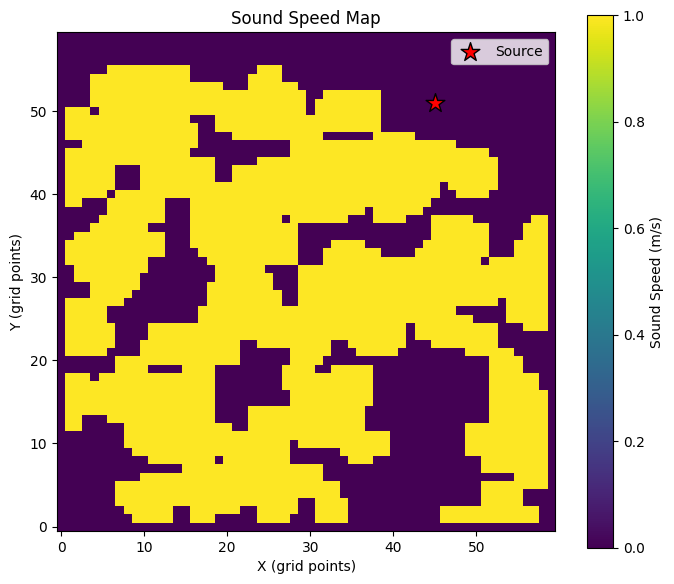

In [26]:
# Get actual grid size from generated maze
Nx, Ny = maze_grid.shape
print(f"Actual grid size after widening: {Nx}x{Ny}")
print(f"Physical size: {Nx*dx:.2f}m × {Ny*dy:.2f}m")

# Create k-Wave grid
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
kgrid.makeTime(c=c_air, cfl=0.3, t_end=sim_duration)

print(f"Time steps: {kgrid.Nt}")
print(f"Time step: {kgrid.dt*1e6:.2f} µs")
print(f"Total time: {sim_duration*1000:.2f} ms")

# Create medium properties
sound_speed = np.full((Nx, Ny), c_air, dtype=np.float32)
sound_speed[maze_grid == 1] = c_wall

density = np.full((Nx, Ny), rho_air, dtype=np.float32)

# Absorption (walls absorb sound)
alpha_coeff = np.zeros((Nx, Ny), dtype=np.float32)
alpha_coeff[maze_grid == 1] = wall_absorption_db_per_cm / ((f0 / 1e6) ** alpha_power)

medium = kWaveMedium(
    sound_speed=sound_speed,
    density=density,
    alpha_coeff=alpha_coeff,
    alpha_power=alpha_power
)

# Visualize sound speed map
plt.figure(figsize=(7, 6))
plt.imshow(sound_speed.T, origin='lower', cmap='viridis')
plt.scatter([source_x], [source_y], s=200, c='red', marker='*',
           edgecolors='black', linewidths=1, label='Source')
plt.title('Sound Speed Map')
plt.xlabel('X (grid points)')
plt.ylabel('Y (grid points)')
plt.colorbar(label='Sound Speed (m/s)')
plt.legend()
plt.axis('image')
plt.tight_layout()
plt.show()

## 4. Create Source and Sensor

In [27]:
# Make sure source is not in wall
if maze_grid[source_y, source_x]:
    print("Source in wall! Finding air position...")
    air_positions = np.argwhere(maze_grid == 0)
    source_y, source_x = air_positions[-1]

print(f"Source position: ({source_y}, {source_x})")
print(f"Source in wall: {maze_grid[source_y, source_x]}")

# Create source
source = kSource()
source_mask = np.zeros((Nx, Ny), dtype=bool)
source_mask[source_y, source_x] = True
source.p_mask = source_mask

# Generate tone burst signal
source.p = tone_burst(1 / kgrid.dt, f0, num_cycles)

print(f"Source signal: {len(source.p)} samples")
print(f"Signal duration: {len(source.p) * kgrid.dt * 1000:.2f} ms")

# CRITICAL: Create sensor to record TIME-SERIES at ALL grid points
# This is necessary for computing spectrograms later!
sensor = kSensor(
    mask=np.ones((Nx, Ny), dtype=bool),  # Record everywhere!
    record=['p']  # Record PRESSURE TIME-SERIES (not p_final/p_rms)
)

print(f"\nSensor recording {sensor.mask.sum()} points")
print(f"Expected output shape: ({Nx*Ny}, {kgrid.Nt})")
print(f"Expected data size: {(Nx*Ny*kgrid.Nt*4)/(1024**2):.1f} MB (float32)")

Source position: (51, 45)
Source in wall: 0
Source signal: 1 samples
Signal duration: 0.01 ms

Sensor recording 3600 points
Expected output shape: (3600, 458)
Expected data size: 6.3 MB (float32)


## 5. Run k-Wave Simulation

This will take longer than before due to recording full time-series

In [28]:
# Simulation options
sim_options = SimulationOptions(
    save_to_disk=True,
    pml_inside=False,
    pml_size=10,
    data_cast='single'  # Use float32 to save memory/speed
)

exec_options = SimulationExecutionOptions(
    is_gpu_simulation=False,
    show_sim_log=True,  # Show progress - should display in console
    verbose_level=2     # More detailed logging
)

print("Running k-Wave simulation...")
print(f"Grid size: {Nx}x{Ny} = {Nx*Ny:,} points")
print(f"Time steps: {kgrid.Nt:,}")
print(f"Total operations: ~{Nx*Ny*kgrid.Nt:,}")
print(f"Expected time: 1-5 minutes (depending on grid size)")

import time
start_time = time.time()

sensor_data = kspaceFirstOrder2D(
    kgrid=kgrid,
    source=source,
    sensor=sensor,
    medium=medium,
    simulation_options=sim_options,
    execution_options=exec_options
)

elapsed = time.time() - start_time
print(f"Simulation complete in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print(f"Data keys: {list(sensor_data.keys())}")
print(f"Pressure data shape: {sensor_data['p'].shape}")
print(f"Actual data size: {sensor_data['p'].nbytes/(1024**2):.1f} MB")

Running k-Wave simulation...
Grid size: 60x60 = 3,600 points
Time steps: 458
Total operations: ~1,648,800
Expected time: 1-5 minutes (depending on grid size)


c:\Users\danyi\repo\Audio-Maze-Navigation\.venv\Lib\site-packages\kwave\options\simulation_execution_options.py:111: UserWarning: Custom binary name set. Ignoring `is_gpu_simulation` state.
  warnings.warn("Custom binary name set. Ignoring `is_gpu_simulation` state.")


+---------------------------------------------------------------+
|                   kspaceFirstOrder-OMP v1.3                   |
+---------------------------------------------------------------+
| Git hash:            0ba023063e3f29685e1e346f56883378d961f9f1 |
+---------------------------------------------------------------+
| Reading simulation configuration:                        Done |
| File format version:                                      1.2 |
| Number of CPU threads:                                     20 |
| Processor name:          13th Gen Intel(R) Core(TM) i9-13900H |
+---------------------------------------------------------------+
|                      Simulation details                       |
+---------------------------------------------------------------+
| Domain dimensions:                                    80 x 80 |
| Medium type:                                               2D |
| Simulation time steps:                                    458 |
+---------

## 6. Visualize Wave Propagation

Compute RMS from time-series for visualization

In [29]:
# Reshape pressure time-series to 3D: (Nx, Ny, Nt)
pressure_timeseries = sensor_data['p'].T  # Shape: (num_timesteps, Nx*Ny)
pressure_field = np.reshape(pressure_timeseries.T, (Nx, Ny, kgrid.Nt), order='F')

print(f"Pressure field shape: {pressure_field.shape}")
print(f"Pressure range: [{pressure_field.min():.3e}, {pressure_field.max():.3e}]")

# Compute p_final (last timestep) and p_rms for visualization
p_final = pressure_field[:, :, -1]
p_rms = np.sqrt(np.mean(pressure_field**2, axis=2))

print(f"Final pressure range: [{p_final.min():.3f}, {p_final.max():.3f}]")
print(f"RMS pressure range: [{p_rms.min():.6f}, {p_rms.max():.6f}]")

# Check if sound reached borders
border_rms = np.concatenate([
    p_rms[0, :],   # Top
    p_rms[-1, :],  # Bottom
    p_rms[:, 0],   # Left
    p_rms[:, -1]   # Right
])

print(f"\nBorder RMS mean: {border_rms.mean():.6f}")
print(f"Border RMS max: {border_rms.max():.6f}")

if border_rms.max() > p_rms.max() * 0.01:
    print("Sound reached borders!")
else:
    print("Sound may not have reached borders")

Pressure field shape: (60, 60, 458)
Pressure range: [-2.658e+00, 2.552e+00]
Final pressure range: [-0.011, 0.011]
RMS pressure range: [0.035867, 0.132665]

Border RMS mean: 0.055489
Border RMS max: 0.132665
Sound reached borders!


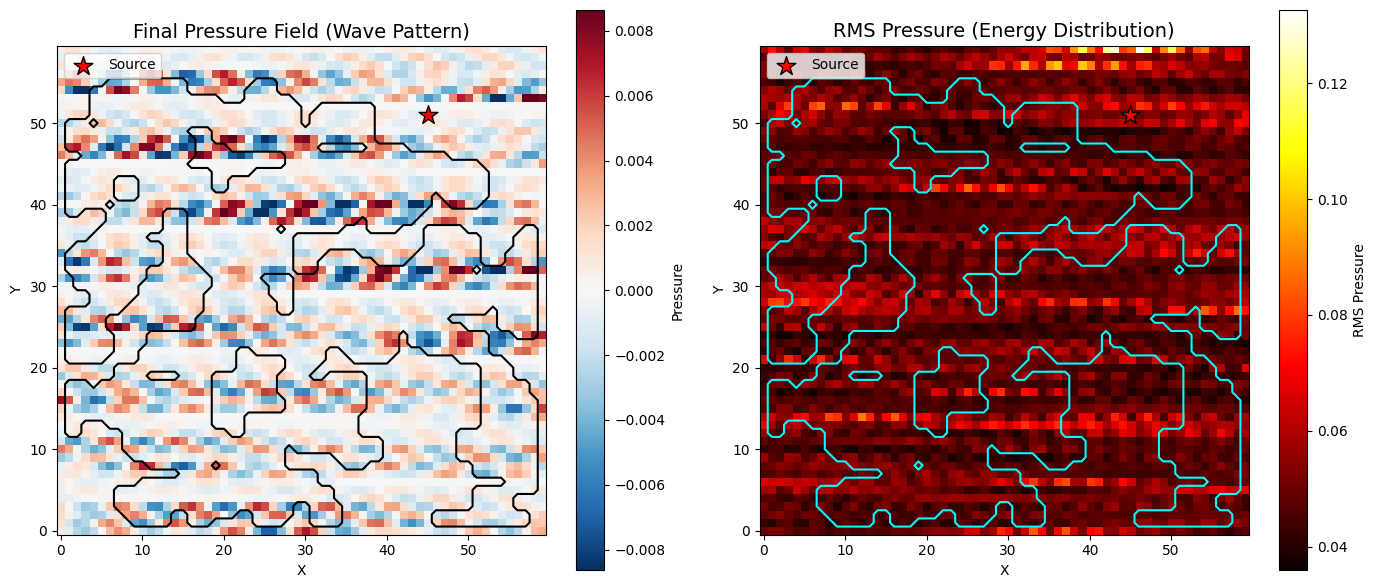

In [30]:
# Plot Final Pressure Field and RMS
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Final pressure
im1 = axes[0].imshow(p_final.T, origin='lower', cmap='RdBu_r', 
                     vmin=-p_final.max()*0.8, vmax=p_final.max()*0.8)
axes[0].contour(maze_grid.T, levels=[0.5], colors='black', linewidths=1.5)
axes[0].scatter([source_x], [source_y], s=200, c='red', marker='*', 
               edgecolors='black', linewidths=1, label='Source', zorder=10)
axes[0].set_title('Final Pressure Field (Wave Pattern)', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend(loc='upper left')
axes[0].axis('image')
plt.colorbar(im1, ax=axes[0], label='Pressure')

# RMS pressure (shows energy distribution)
im2 = axes[1].imshow(p_rms.T, origin='lower', cmap='hot')
axes[1].contour(maze_grid.T, levels=[0.5], colors='cyan', linewidths=1.5)
axes[1].scatter([source_x], [source_y], s=200, c='red', marker='*',
               edgecolors='black', linewidths=1, label='Source', zorder=10)
axes[1].set_title('RMS Pressure (Energy Distribution)', fontsize=14)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend(loc='upper left')
axes[1].axis('image')
plt.colorbar(im2, ax=axes[1], label='RMS Pressure')

plt.tight_layout()
plt.show()

## 7. Save Dataset to HDF5

Save all data needed for training: maze, actions, and acoustic time-series

In [31]:
# Create HDF5 file for this maze
output_file = OUTPUT_DIR / 'acoustic_maze_dataset.h5'

with h5py.File(output_file, 'w') as f:
    # Create group for this maze
    maze_group = f.create_group('maze_0001')
    
    # Save maze structure
    maze_group.create_dataset('maze_grid', data=maze_grid, compression='gzip')
    maze_group.create_dataset('action_grid', data=action_grid.astype('S10'), compression='gzip')
    
    # Save acoustic data (this is the big one!)
    maze_group.create_dataset('pressure_timeseries', data=pressure_field, 
                             compression='gzip', compression_opts=4)
    
    # Save metadata
    maze_group.attrs['source_position'] = [source_y, source_x]
    maze_group.attrs['grid_size'] = [Nx, Ny]
    maze_group.attrs['resolution_m'] = dx
    maze_group.attrs['frequency_hz'] = f0
    maze_group.attrs['num_timesteps'] = kgrid.Nt
    maze_group.attrs['dt'] = kgrid.dt
    maze_group.attrs['sim_duration_s'] = sim_duration
    maze_group.attrs['sound_speed_air'] = c_air
    maze_group.attrs['sound_speed_wall'] = c_wall

print(f"Dataset saved to {output_file}")
print(f"  File size: {output_file.stat().st_size / (1024**2):.1f} MB")
print(f"\nDataset structure:")
print(f"  maze_grid: {maze_grid.shape} - Wall/air layout")
print(f"  action_grid: {action_grid.shape} - Action labels")
print(f"  pressure_timeseries: {pressure_field.shape} - Acoustic data")
print(f"\nTo load later:")
print(f"  with h5py.File('{output_file}', 'r') as f:")
print(f"      maze_data = f['maze_0001']")
print(f"      pressure = maze_data['pressure_timeseries'][:]")

Dataset saved to ..\dataset\acoustic_maze_dataset.h5
  File size: 6.1 MB

Dataset structure:
  maze_grid: (60, 60) - Wall/air layout
  action_grid: (60, 60) - Action labels
  pressure_timeseries: (60, 60, 458) - Acoustic data

To load later:
  with h5py.File('..\dataset\acoustic_maze_dataset.h5', 'r') as f:
      maze_data = f['maze_0001']
      pressure = maze_data['pressure_timeseries'][:]


## 8. Comprehensive Acoustic Analysis for Navigation

Extract 8-mic array and analyze for sound-based navigation

AGENT POSITION ANALYSIS
Agent location: (18, 25)
Optimal action: 'down'
Distance to goal: 38.6 cells

8-MIC ARRAY:
  Array shape: (8, 458)
  Valid mics: 8/8
  Sampling rate: 114333 Hz
  Duration: 4.01 ms
  Time array shape: (458,)
Saved comprehensive analysis to ..\dataset\acoustic_analysis.png


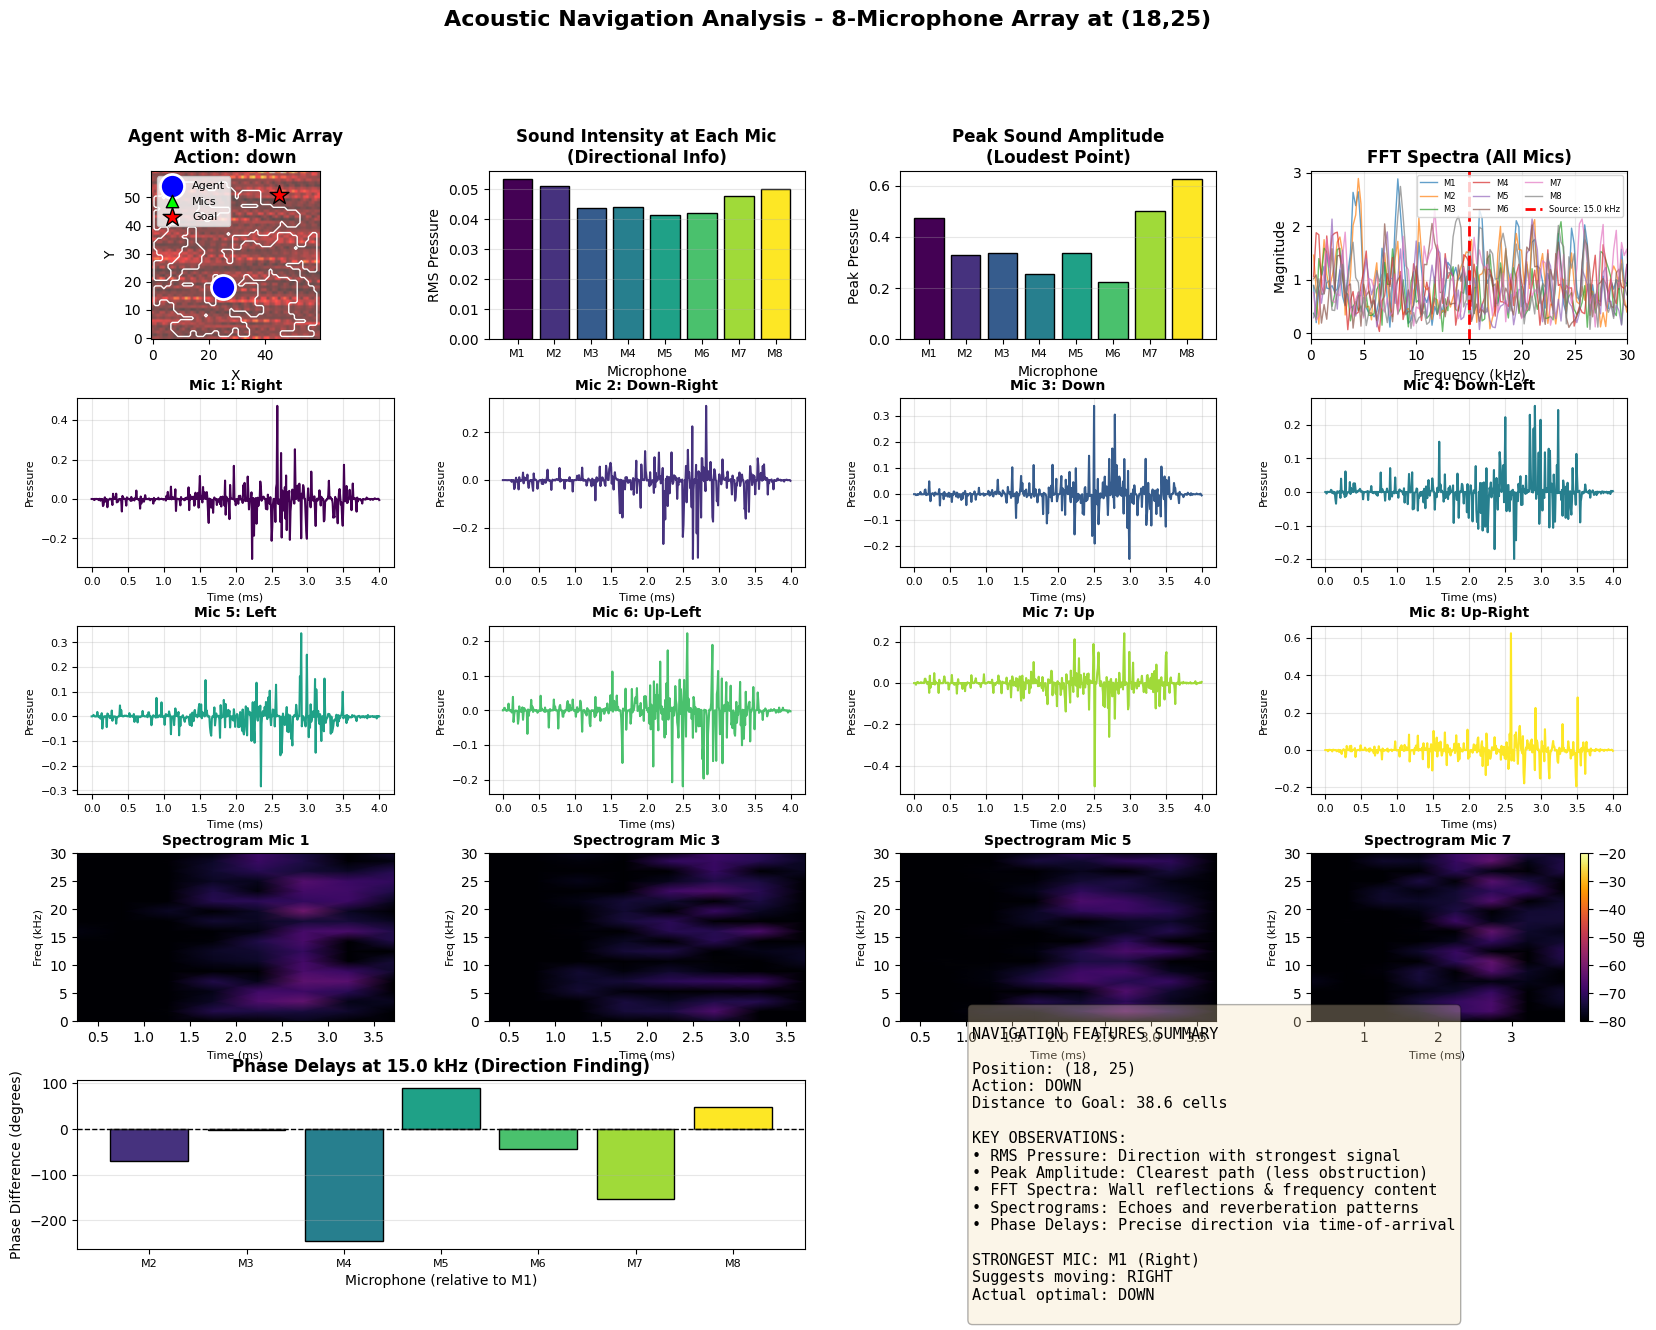

ACOUSTIC NAVIGATION FEATURES AVAILABLE:
1. RMS Pressure: Shows which direction has strongest signal
2. Peak Amplitude: Identifies clearest path (less obstruction)
3. FFT Spectra: Frequency content shows wall reflections
4. Spectrograms: Time-frequency shows echoes and reverb
5. Phase Differences: Direction finding via time-of-arrival


In [32]:
# Pick a random agent position in navigable space
air_positions = np.argwhere(maze_grid == 0)
agent_pos = air_positions[len(air_positions)//3]  # Pick a position (not goal)
agent_y, agent_x = agent_pos

print(f"AGENT POSITION ANALYSIS")
print(f"Agent location: ({agent_y}, {agent_x})")
print(f"Optimal action: '{action_grid[agent_y, agent_x]}'")
print(f"Distance to goal: {np.sqrt((agent_y - source_y)**2 + (agent_x - source_x)**2):.1f} cells")

# Define 8-mic circular array (radius = 1 grid cell)
mic_offsets = [
    (0, 1),   # Right
    (1, 1),   # Down-right
    (1, 0),   # Down
    (1, -1),  # Down-left
    (0, -1),  # Left
    (-1, -1), # Up-left
    (-1, 0),  # Up
    (-1, 1)   # Up-right
]

# Extract 8-mic time-series
mic_timeseries = []
valid_mics = []
mic_labels = ['Right', 'Down-Right', 'Down', 'Down-Left', 'Left', 'Up-Left', 'Up', 'Up-Right']

for idx, (dy, dx) in enumerate(mic_offsets):
    mic_y, mic_x = agent_y + dy, agent_x + dx
    
    if 0 <= mic_y < Ny and 0 <= mic_x < Nx and maze_grid[mic_y, mic_x] == 0:
        mic_timeseries.append(pressure_field[mic_y, mic_x, :])
        valid_mics.append((mic_y, mic_x, mic_labels[idx]))
    else:
        # Fallback to agent position if mic in wall
        mic_timeseries.append(pressure_field[agent_y, agent_x, :])
        valid_mics.append((agent_y, agent_x, mic_labels[idx] + " (fallback)"))

mic_timeseries = np.array(mic_timeseries)  # Shape: (8, Nt)

# Create time array (flatten if needed)
time_array = np.asarray(kgrid.t_array).flatten() * 1000  # Convert to ms

print(f"\n8-MIC ARRAY:")
print(f"  Array shape: {mic_timeseries.shape}")
print(f"  Valid mics: {len([m for m in valid_mics if 'fallback' not in m[2]])}/8")
print(f"  Sampling rate: {1/kgrid.dt:.0f} Hz")
print(f"  Duration: {kgrid.Nt * kgrid.dt * 1000:.2f} ms")
print(f"  Time array shape: {time_array.shape}")
print(f"="*70)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(5, 4, hspace=0.35, wspace=0.3)

# Row 0: Overview
# 1. Agent Position in Cave
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(p_rms.T, origin='lower', cmap='hot', alpha=0.7)
ax1.contour(maze_grid.T, levels=[0.5], colors='white', linewidths=1)
ax1.scatter([agent_x], [agent_y], s=300, c='blue', marker='o', 
           edgecolors='white', linewidths=2, label='Agent', zorder=10)
mic_xs = [m[1] for m in valid_mics]
mic_ys = [m[0] for m in valid_mics]
ax1.scatter(mic_xs, mic_ys, s=80, c='lime', marker='^',
           edgecolors='black', linewidths=1, label='Mics', zorder=9)
ax1.scatter([source_x], [source_y], s=200, c='red', marker='*',
           edgecolors='black', linewidths=1, label='Goal', zorder=10)
ax1.set_title(f'Agent with 8-Mic Array\nAction: {action_grid[agent_y, agent_x]}', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend(fontsize=8)
ax1.axis('image')

# 2. RMS Pressure at Each Mic (shows directionality)
ax2 = fig.add_subplot(gs[0, 1])
mic_rms = np.sqrt(np.mean(mic_timeseries**2, axis=1))
colors = plt.cm.viridis(np.linspace(0, 1, 8))
bars = ax2.bar(range(8), mic_rms, color=colors, edgecolor='black', linewidth=1)
ax2.set_xlabel('Microphone')
ax2.set_ylabel('RMS Pressure')
ax2.set_title('Sound Intensity at Each Mic\n(Directional Info)', fontsize=12, fontweight='bold')
ax2.set_xticks(range(8))
ax2.set_xticklabels([f'M{i+1}' for i in range(8)], fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Peak Pressure (Max Amplitude)
ax3 = fig.add_subplot(gs[0, 2])
mic_peak = np.max(np.abs(mic_timeseries), axis=1)
bars = ax3.bar(range(8), mic_peak, color=colors, edgecolor='black', linewidth=1)
ax3.set_xlabel('Microphone')
ax3.set_ylabel('Peak Pressure')
ax3.set_title('Peak Sound Amplitude\n(Loudest Point)', fontsize=12, fontweight='bold')
ax3.set_xticks(range(8))
ax3.set_xticklabels([f'M{i+1}' for i in range(8)], fontsize=8)
ax3.grid(True, alpha=0.3, axis='y')

# 4. FFT Spectra for all mics
ax4 = fig.add_subplot(gs[0, 3])
for i in range(8):
    fft_vals = fft(mic_timeseries[i, :])
    freqs = fftfreq(len(mic_timeseries[i, :]), kgrid.dt)
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    fft_mag = np.abs(fft_vals[pos_mask])
    ax4.plot(freqs_pos / 1000, fft_mag, label=f'M{i+1}', alpha=0.7, linewidth=1)
ax4.set_xlabel('Frequency (kHz)', fontsize=10)
ax4.set_ylabel('Magnitude', fontsize=10)
ax4.set_title('FFT Spectra (All Mics)', fontsize=12, fontweight='bold')
ax4.set_xlim([0, 30])
ax4.axvline(f0/1000, color='red', linestyle='--', linewidth=2, label=f'Source: {f0/1000:.1f} kHz')
ax4.legend(fontsize=6, ncol=3)
ax4.grid(True, alpha=0.3)

# Row 1-2: Time Series for Mics 1-4
for i in range(4):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(time_array, mic_timeseries[i, :], linewidth=1.5, color=colors[i])
    ax.set_title(f'Mic {i+1}: {mic_labels[i]}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (ms)', fontsize=8)
    ax.set_ylabel('Pressure', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Row 2: Time Series for Mics 5-8
for i in range(4, 8):
    ax = fig.add_subplot(gs[2, i-4])
    ax.plot(time_array, mic_timeseries[i, :], linewidth=1.5, color=colors[i])
    ax.set_title(f'Mic {i+1}: {mic_labels[i]}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Time (ms)', fontsize=8)
    ax.set_ylabel('Pressure', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Row 3: Spectrograms for 4 mics
for idx, mic_idx in enumerate([0, 2, 4, 6]):  # Mics 1, 3, 5, 7
    ax = fig.add_subplot(gs[3, idx])
    f_spec, t_spec, Sxx = scipy_signal.spectrogram(mic_timeseries[mic_idx, :], fs=1/kgrid.dt,
                                                    nperseg=min(64, len(mic_timeseries[mic_idx, :])))
    pcm = ax.pcolormesh(t_spec * 1000, f_spec / 1000, 10 * np.log10(Sxx + 1e-10), 
                        shading='gouraud', cmap='inferno', vmin=-80, vmax=-20)
    ax.set_ylabel('Freq (kHz)', fontsize=8)
    ax.set_xlabel('Time (ms)', fontsize=8)
    ax.set_title(f'Spectrogram Mic {mic_idx+1}', fontsize=10, fontweight='bold')
    ax.set_ylim([0, 30])
    if idx == 3:
        plt.colorbar(pcm, ax=ax, label='dB')

# Row 4: Phase Analysis and Summary
# Phase Differences (relative to Mic 1)
ax_phase = fig.add_subplot(gs[4, 0:2])
phase_diffs = []
for i in range(1, 8):
    fft1 = fft(mic_timeseries[0, :])
    fft_i = fft(mic_timeseries[i, :])
    freq_idx = np.argmin(np.abs(fftfreq(len(mic_timeseries[0, :]), kgrid.dt) - f0))
    phase_diff = np.angle(fft_i[freq_idx]) - np.angle(fft1[freq_idx])
    phase_diffs.append(np.degrees(phase_diff))
ax_phase.bar(range(1, 8), phase_diffs, color=colors[1:], edgecolor='black', linewidth=1)
ax_phase.set_xlabel('Microphone (relative to M1)', fontsize=10)
ax_phase.set_ylabel('Phase Difference (degrees)', fontsize=10)
ax_phase.set_title(f'Phase Delays at {f0/1000:.1f} kHz (Direction Finding)', fontsize=12, fontweight='bold')
ax_phase.set_xticks(range(1, 8))
ax_phase.set_xticklabels([f'M{i+1}' for i in range(1, 8)], fontsize=8)
ax_phase.axhline(0, color='black', linestyle='--', linewidth=1)
ax_phase.grid(True, alpha=0.3, axis='y')

# Summary Text
ax_text = fig.add_subplot(gs[4, 2:])
ax_text.axis('off')
summary_text = f"""
NAVIGATION FEATURES SUMMARY

Position: ({agent_y}, {agent_x})
Action: {action_grid[agent_y, agent_x].upper()}
Distance to Goal: {np.sqrt((agent_y-source_y)**2 + (agent_x-source_x)**2):.1f} cells

KEY OBSERVATIONS:
• RMS Pressure: Direction with strongest signal
• Peak Amplitude: Clearest path (less obstruction)
• FFT Spectra: Wall reflections & frequency content
• Spectrograms: Echoes and reverberation patterns
• Phase Delays: Precise direction via time-of-arrival

STRONGEST MIC: M{np.argmax(mic_rms)+1} ({mic_labels[np.argmax(mic_rms)]})
Suggests moving: {mic_labels[np.argmax(mic_rms)].upper()}
Actual optimal: {action_grid[agent_y, agent_x].upper()}
"""
ax_text.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Acoustic Navigation Analysis - 8-Microphone Array at ({agent_y},{agent_x})',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig(OUTPUT_DIR / 'acoustic_analysis.png', dpi=150, bbox_inches='tight')
print(f"Saved comprehensive analysis to {OUTPUT_DIR / 'acoustic_analysis.png'}")
plt.show()


print("ACOUSTIC NAVIGATION FEATURES AVAILABLE:")
print(f"1. RMS Pressure: Shows which direction has strongest signal")
print(f"2. Peak Amplitude: Identifies clearest path (less obstruction)")
print(f"3. FFT Spectra: Frequency content shows wall reflections")
print(f"4. Spectrograms: Time-frequency shows echoes and reverb")
print(f"5. Phase Differences: Direction finding via time-of-arrival")